In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from torchvision import models, transforms
from misc_functions import preprocess_image

In [2]:
class SaveValues():
    def __init__(self, m):
        # register a hook to save values of activations and gradients
        self.activations = None
        self.gradients = None
        self.forward_hook = m.register_forward_hook(self.hook_fn_act)
        self.backward_hook = m.register_backward_hook(self.hook_fn_grad)

    def hook_fn_act(self, module, input, output):
        self.activations = output

    def hook_fn_grad(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def remove(self):
        self.forward_hook.remove()
        self.backward_hook.remove()

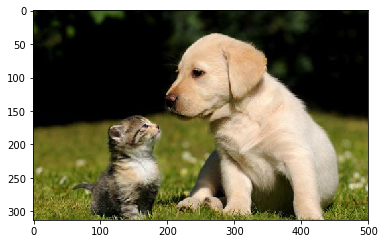

In [7]:
img_path = '../input_images/c.jpg'
original_image = Image.open(img_path).convert('RGB')
image_size = original_image.size
plt.imshow(original_image)

In [8]:
# Process image
prep_img = preprocess_image(original_image)
# Define model
pretrained_model = models.vgg16(pretrained=True)
pretrained_model.eval()
print(pretrained_model)
target_class = None
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
pretrained_model.to(device)
prep_img = prep_img.cuda()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [9]:
target_layer = pretrained_model.features[28]
x = prep_img
values = SaveValues(target_layer)
model_output = pretrained_model(x)
conv_output = values.activations
prob = F.softmax(model_output, dim=1)
p, target_class = torch.max(prob, dim=1)
# target_class = 282
target = conv_output[0]
cam = np.zeros(target.shape[1:], dtype=np.float32)
saliency_map1 = torch.unsqueeze(torch.unsqueeze(target[0, :, :],0),0)
target_numpy = target.cpu().detach().numpy()
for i in range(len(target)):
    if target[i, :, :].max() == target[i, :, :].min():
        continue
    template = np.where(target_numpy[i, :, :]>0,1,0)
    activations_cuda = [target_numpy[k, :, :]*template for k in range(len(target))]
    activations_cuda = np.array(activations_cuda)[None]
    activations_cuda = torch.from_numpy(activations_cuda).float().cuda()
    mm = pretrained_model.avgpool(pretrained_model.features[30](pretrained_model.features[29](activations_cuda)))
    mm = mm.view(mm.size(0), -1)
    w = F.softmax(pretrained_model.classifier(mm),dim=1)[0][target_class]
    cam += w.data.cpu().numpy() * target[i, :, :].data.cpu().numpy()
cam = np.maximum(cam, 0)
cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))
cam = np.uint8(cam * 255)
cam = np.uint8(Image.fromarray(cam).resize((prep_img.shape[2],prep_img.shape[3]), Image.ANTIALIAS))/255

/home/zhengmen/anaconda3/lib/python3.7/site-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


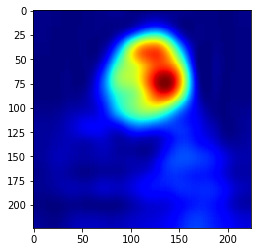

In [10]:
import matplotlib.pyplot as plt
plt.imshow(cam,cmap='jet')